=== Run 1 ===


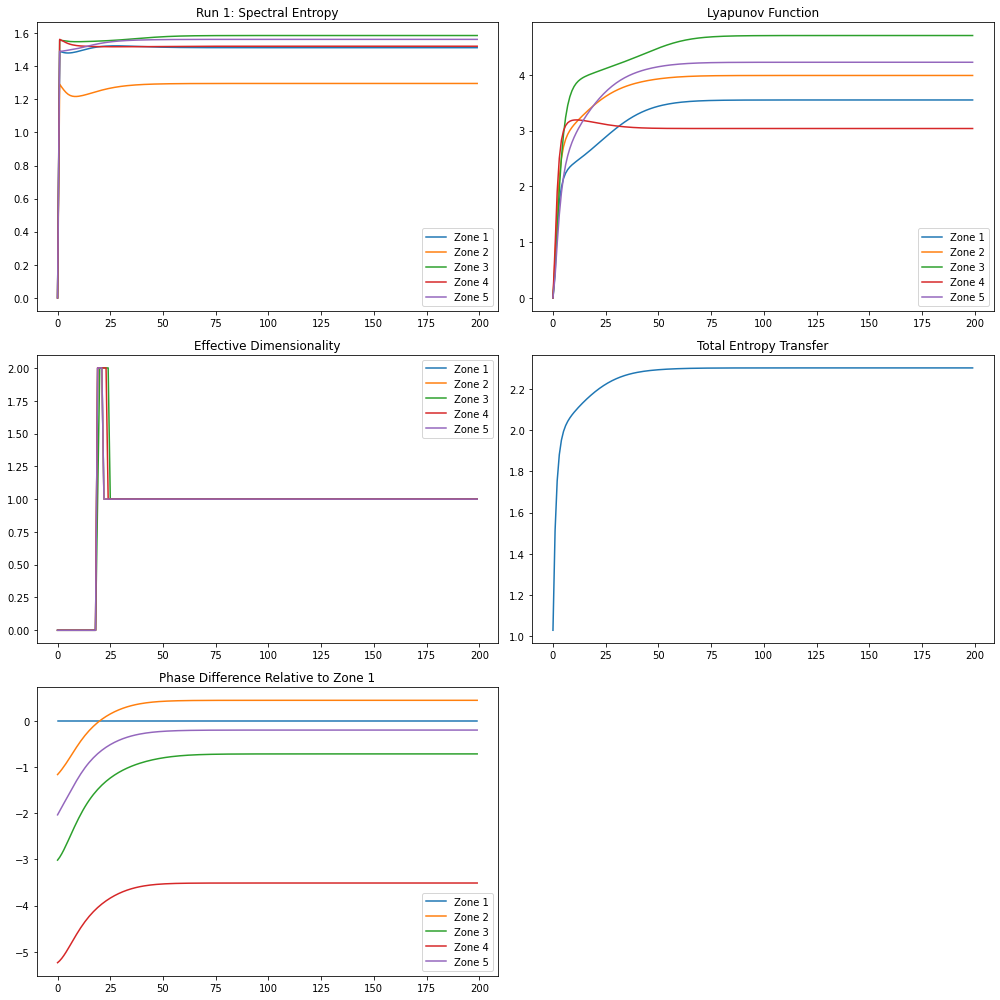

=== Run 2 ===


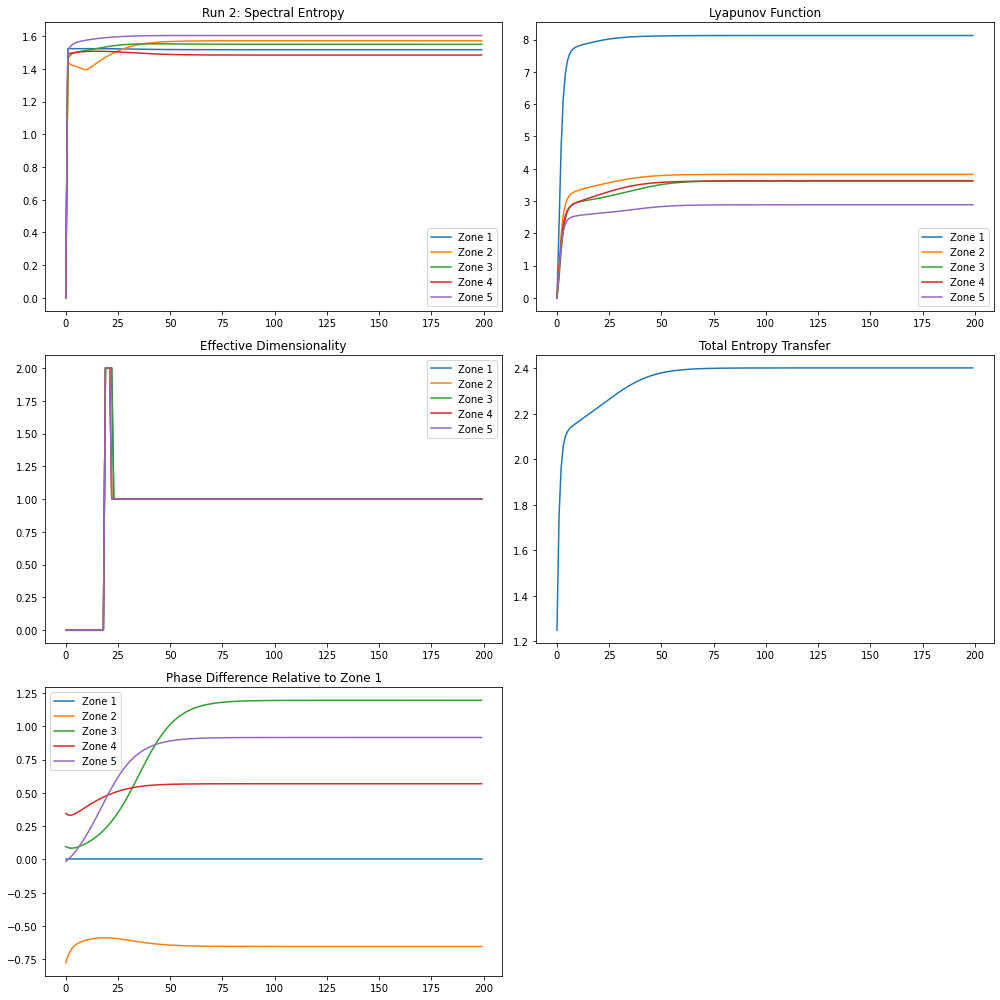

=== Run 3 ===


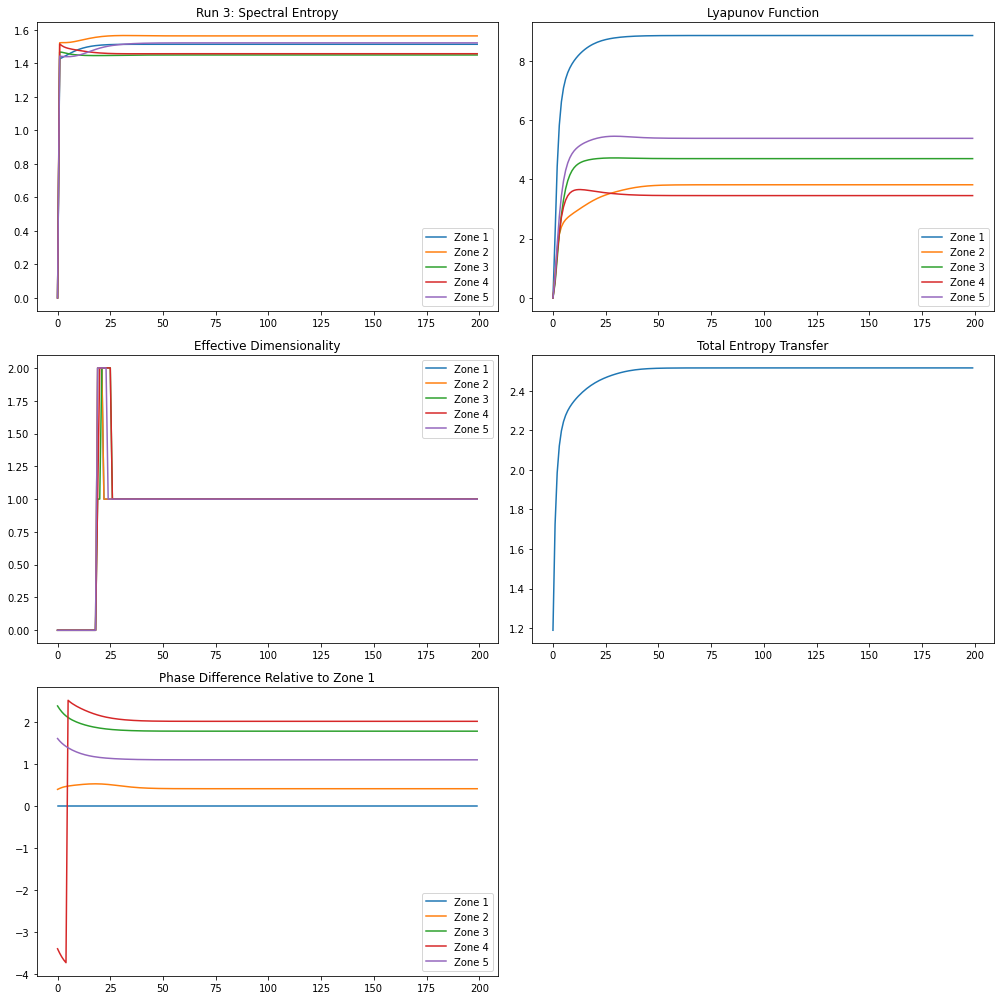

=== Run 4 ===


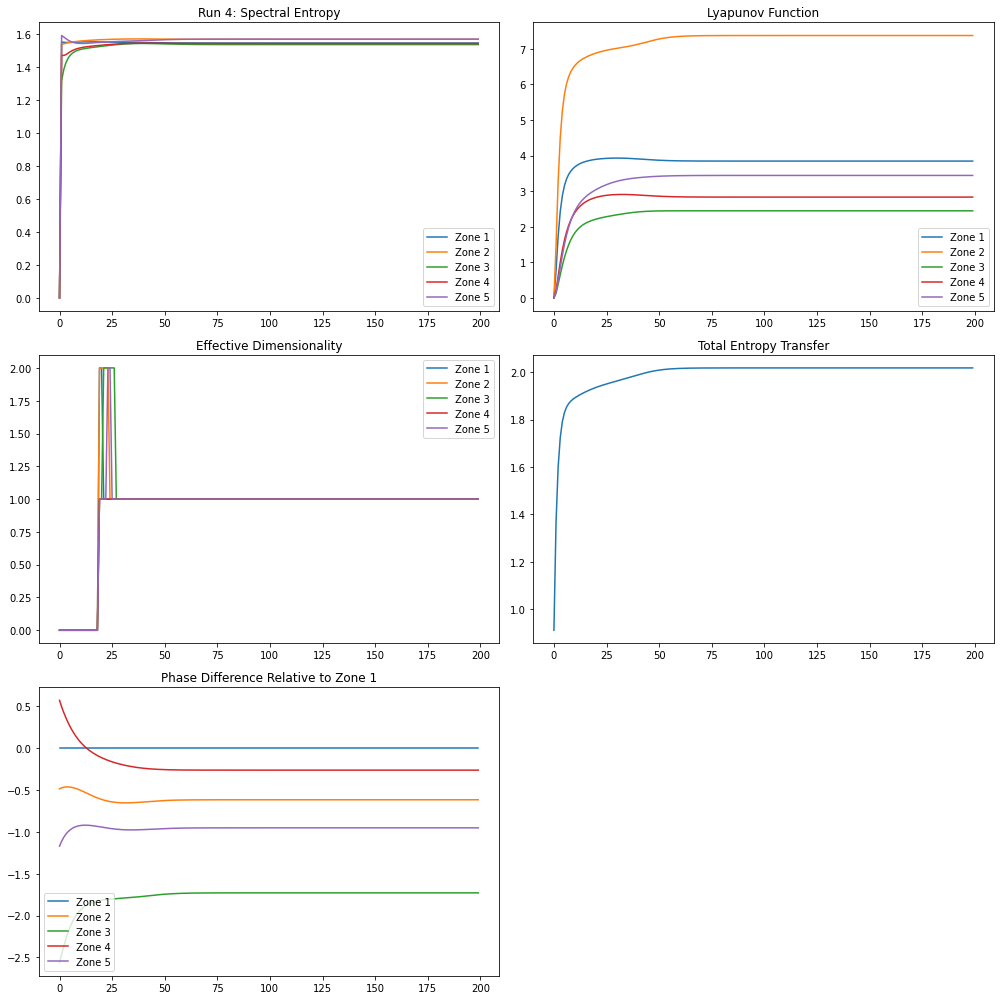

=== Run 5 ===


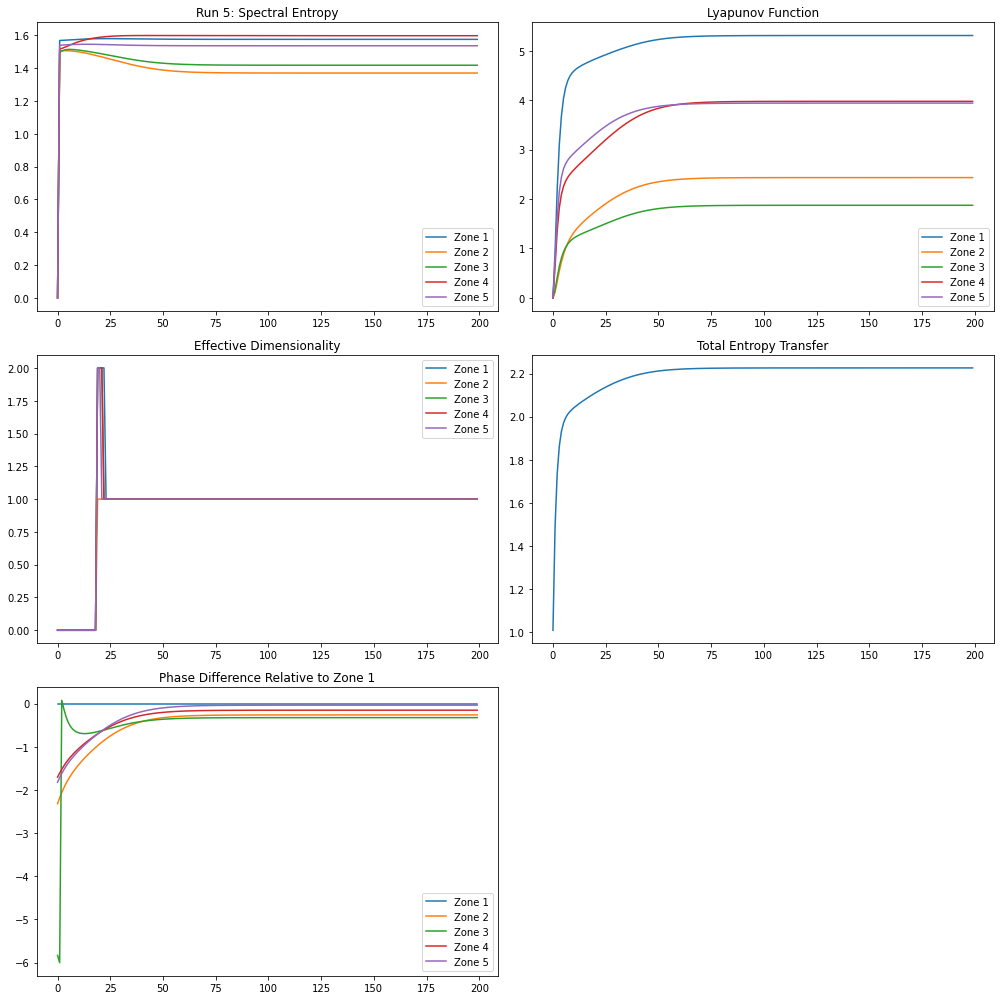

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# --- Parameters ---
N = 5  # Number of spectral modes
num_zones = 5
runs = 5  # Number of randomized runs

# Simulation constants
timesteps = 200
buffer_size = 20
pca_threshold = 0.05

def spectral_entropy(S):
    mag = np.abs(S)
    probs = mag / np.sum(mag + 1e-9)
    return -np.sum(probs * np.log(probs + 1e-9))

def chaos_perturb(S, chaos_strength):
    clipped_real = np.clip(S.real, 0, 1)
    clipped_imag = np.clip(S.imag, 0, 1)
    perturb_real = chaos_strength * (3.9 * clipped_real * (1 - clipped_real))
    perturb_imag = chaos_strength * (3.9 * clipped_imag * (1 - clipped_imag))
    return perturb_real + 1j * perturb_imag

def lyapunov_function(S, target=0):
    return np.sum(np.abs(S - target)**2)

for run in range(runs):
    print(f"=== Run {run + 1} ===")

    # Randomized parameters
    mu_vals = np.random.uniform(0.3, 0.9, num_zones)
    delta_vals = np.random.uniform(0.02, 0.08, num_zones)
    chaos_strength_base = np.random.uniform(0.02, 0.07)

    Psi = [np.random.randn(N) + 1j * np.random.randn(N) for _ in range(num_zones)]
    S_memory = [np.zeros(N, dtype=complex) for _ in range(num_zones)]

    entropy_log = [[] for _ in range(num_zones)]
    lyapunov_log = [[] for _ in range(num_zones)]
    dimensionality_log = [[] for _ in range(num_zones)]
    phase_diff_log = [[] for _ in range(num_zones)]
    transfer_log = []

    pca_buffer = [[] for _ in range(num_zones)]

    for t in range(timesteps):
        # Lyapunov & adaptive parameters
        V = [lyapunov_function(S) for S in S_memory]
        chaos_strength = [chaos_strength_base * np.exp(-0.001 * v) for v in V]
        entropy = [spectral_entropy(S) for S in S_memory]
        tau = [0.5 * np.exp(-0.01 * e) for e in entropy]

        for i in range(num_zones):
            Psi[i] += chaos_perturb(Psi[i], chaos_strength[i])
            S_memory[i] = (1 - mu_vals[i] * tau[i]) * S_memory[i] + mu_vals[i] * tau[i] * Psi[i] - mu_vals[i] * delta_vals[i] * S_memory[i]

        # Communication
        for i in range(num_zones):
            for j in range(num_zones):
                if i != j:
                    transfer = 0.05 * (S_memory[j] - S_memory[i])
                    S_memory[i] += transfer

        # Logging
        for i in range(num_zones):
            entropy_log[i].append(entropy[i])
            lyapunov_log[i].append(V[i])
            pca_buffer[i].append(np.concatenate((S_memory[i].real, S_memory[i].imag)))
            # Phase diff to zone 0
            phase_diff_log[i].append(np.angle(np.mean(S_memory[i])) - np.angle(np.mean(S_memory[0])))

        transfer_magnitude = sum(np.linalg.norm(0.05 * (S_memory[j] - S_memory[i])) for i in range(num_zones) for j in range(num_zones) if i != j)
        transfer_log.append(transfer_magnitude)

        for i in range(num_zones):
            if len(pca_buffer[i]) >= buffer_size:
                pca_data = np.array(pca_buffer[i][-buffer_size:])
                pca = PCA(n_components=min(buffer_size, 2*N))
                pca.fit(pca_data)
                dimensionality_log[i].append(np.sum(pca.explained_variance_ratio_ > pca_threshold))
            else:
                dimensionality_log[i].append(0)

    # Plotting per run
    fig, axs = plt.subplots(3, 2, figsize=(14, 14))

    for i in range(num_zones):
        axs[0, 0].plot(entropy_log[i], label=f'Zone {i+1}')
    axs[0, 0].set_title(f'Run {run+1}: Spectral Entropy')
    axs[0, 0].legend()

    for i in range(num_zones):
        axs[0, 1].plot(lyapunov_log[i], label=f'Zone {i+1}')
    axs[0, 1].set_title('Lyapunov Function')
    axs[0, 1].legend()

    for i in range(num_zones):
        axs[1, 0].plot(dimensionality_log[i], label=f'Zone {i+1}')
    axs[1, 0].set_title('Effective Dimensionality')
    axs[1, 0].legend()

    axs[1, 1].plot(transfer_log)
    axs[1, 1].set_title('Total Entropy Transfer')

    for i in range(num_zones):
        axs[2, 0].plot(phase_diff_log[i], label=f'Zone {i+1}')
    axs[2, 0].set_title('Phase Difference Relative to Zone 1')
    axs[2, 0].legend()

    axs[2, 1].axis('off')

    plt.tight_layout()
    plt.show()
